In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read Data

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


## Text Preprocessing

In [4]:
# Convert positive to 1 and negative to 0
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_num = ordinal_encoder.fit_transform(df[['sentiment']])
df['num_sentiment'] = df_num

In [5]:
df.drop(['sentiment'], axis=1, inplace=True)

In [6]:
df.head(2)

,review,num_sentiment
0,One of the other reviewers has mentioned that ...,1.0
1,A wonderful little production. <br /><br />The...,1.0


In [7]:
# Remove html coding
df['review'] = df['review'].str.replace('<.*?>','')

In [8]:
# Remove all puncuation and symbols
df['review'] = df['review'].str.replace('[^\w\s]','')

In [9]:
# Make everything lower case
df['review'] = df['review'].str.lower()

#### Tokenize

In [10]:
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [11]:
df['tokens'] = df.review.apply(lambda row: w_tokenizer.tokenize(row))

Make a copy before we go further

In [12]:
df_wsw = df.copy()

## Prepare for LDA

Code from this section was referenced from the follow sites:
* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html#constructing-a-document-term-matrix
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

In [13]:
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
import gensim
from pprint import pprint

In [14]:
bigram = gensim.models.Phrases(df_wsw['tokens'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_wsw['tokens']], threshold=100) 

In [15]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
# Example
print(trigram_mod[bigram_mod[df_wsw['tokens'][0]]])

['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'youll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'methe', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'wordit', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum_security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison', 'where', 'all', 'the', 'cells', 'have', 'gla

#### Remove Stopwords

In [17]:
# Remove stop words
import spacy

sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
all_stopwords = sp.Defaults.stop_words
# # After seeing the word counts, update stop words
sp.Defaults.stop_words |= {'movie', 'film'}

In [18]:
all_stopwords.remove('not')

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = sp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
no_stops = remove_stopwords(df_wsw['tokens'])

# Form Bigrams
no_stops_bigrams = make_bigrams(no_stops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(no_stops_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['reviewer', 'mention', 'watch', 'episode', 'hooked', 'right', 'exactly', 'happen', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'wordit', 'call', 'nickname', 'give', 'oswald', 'maximum_security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'privacy', 'high', 'agenda', 'city', 'home', 'manyaryan', 'muslim', 'gangsta', 'latinos', 'christian', 'italian', 'irish', 'moreso', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'awayi', 'main', 'appeal', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romanceoz', 'do', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'developed', 'taste', 'get', 'accustom', 'high

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [22]:
# Create Corpus
texts = data_lemmatized

In [23]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 3), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=42,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [25]:
pprint(lda_model.print_topics())

[(0,
  '0.090*"woman" + 0.076*"horror" + 0.027*"favorite" + 0.025*"killer" + '
  '0.023*"sad" + 0.022*"female" + 0.022*"general" + 0.021*"hilarious" + '
  '0.019*"victim" + 0.018*"soundtrack"'),
 (1,
  '0.097*"dead" + 0.063*"body" + 0.042*"doctor" + 0.030*"scientist" + '
  '0.025*"naked" + 0.023*"attractive" + 0.021*"sport" + 0.021*"religious" + '
  '0.018*"church" + 0.017*"australian"'),
 (2,
  '0.035*"local" + 0.031*"remain" + 0.026*"student" + 0.026*"animal" + '
  '0.025*"fantasy" + 0.025*"particular" + 0.021*"sadly" + 0.018*"study" + '
  '0.018*"appearance" + 0.018*"club"'),
 (3,
  '0.068*"british" + 0.047*"indian" + 0.033*"brief" + 0.029*"joe" + '
  '0.027*"plane" + 0.026*"favor" + 0.023*"vhs" + 0.023*"network" + '
  '0.022*"price" + 0.019*"subtitle"'),
 (4,
  '0.221*"comedy" + 0.067*"career" + 0.047*"entertain" + 0.044*"match" + '
  '0.032*"studio" + 0.027*"decade" + 0.025*"tom" + 0.020*"buddy" + '
  '0.018*"slapstick" + 0.017*"nazi"'),
 (5,
  '0.065*"family" + 0.045*"wife" + 0.0

## Coherence Score

In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.27144113273013215


### Our Coherence Score is low. Find the optimal number of topics.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                                           update_every=1, chunksize=100, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=40, step=6)

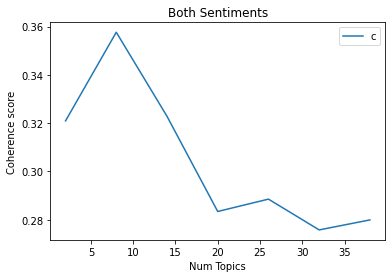

In [29]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title('Both Sentiments')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3209
Num Topics = 8  has Coherence Value of 0.3577
Num Topics = 14  has Coherence Value of 0.3229
Num Topics = 20  has Coherence Value of 0.2834
Num Topics = 26  has Coherence Value of 0.2885
Num Topics = 32  has Coherence Value of 0.2758
Num Topics = 38  has Coherence Value of 0.2799


In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=8, random_state=42,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [42]:
pprint(lda_model.print_topics())

[(0,
  '0.032*"horror" + 0.020*"kill" + 0.013*"flick" + 0.012*"evil" + '
  '0.011*"favorite" + 0.010*"sequel" + 0.010*"killer" + 0.010*"blood" + '
  '0.010*"special_effect" + 0.009*"cheap"'),
 (1,
  '0.021*"wife" + 0.019*"father" + 0.017*"house" + 0.016*"mother" + '
  '0.015*"dead" + 0.013*"son" + 0.012*"daughter" + 0.011*"sister" + '
  '0.010*"family" + 0.010*"body"'),
 (2,
  '0.015*"story" + 0.011*"film" + 0.010*"man" + 0.010*"life" + '
  '0.009*"character" + 0.009*"play" + 0.007*"love" + 0.007*"work" + '
  '0.007*"great" + 0.006*"performance"'),
 (3,
  '0.027*"series" + 0.022*"book" + 0.021*"episode" + 0.010*"game" + '
  '0.008*"version" + 0.008*"novel" + 0.008*"mystery" + 0.008*"season" + '
  '0.007*"team" + 0.007*"villain"'),
 (4,
  '0.028*"match" + 0.013*"japan" + 0.013*"likable" + 0.011*"nazi" + '
  '0.010*"devil" + 0.010*"satire" + 0.010*"card" + 0.009*"grip" + '
  '0.009*"abuse" + 0.008*"billy"'),
 (5,
  '0.037*"war" + 0.030*"murder" + 0.017*"soldier" + 0.015*"police" + '
  '0

In [43]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3666779420571924


In [44]:
'''
Code reference from:
https://www.kaggle.com/kamilpolak/topic-modeling-with-lda
'''

import matplotlib.gridspec as gridspec
k = 8
# tweets_lda = LdaModel(corpus, num_topics = k, id2word = dictionary, passes=10)

def plot_top_words(lda=lda_model, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

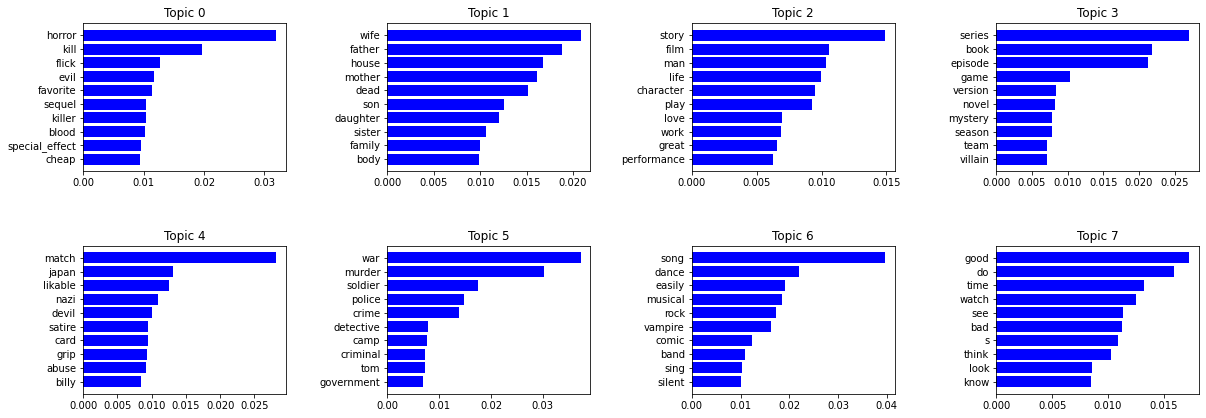

In [45]:
plot_top_words()

### Positive and Negative LDAs

In [72]:
pos_ind = df_wsw[df_wsw['num_sentiment'] == 1.0].index.tolist()
neg_ind = df_wsw[df_wsw['num_sentiment'] == 0.0].index.tolist()

In [73]:
# Remove Stop Words
no_stops_pos=[no_stops[i] for i in pos_ind]
no_stops_neg=[no_stops[i] for i in neg_ind]

# Form Bigrams
no_stops_bigrams_pos = make_bigrams(no_stops_pos)
no_stops_bigrams_neg = make_bigrams(no_stops_neg)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_pos = lemmatization(no_stops_bigrams_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_neg = lemmatization(no_stops_bigrams_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_pos[:1])
print(data_lemmatized_neg[:1])

[['reviewer', 'mention', 'watch', 'episode', 'hooked', 'right', 'exactly', 'happen', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'wordit', 'call', 'nickname', 'give', 'oswald', 'maximum_security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'privacy', 'high', 'agenda', 'city', 'home', 'manyaryan', 'muslim', 'gangsta', 'latinos', 'christian', 'italian', 'irish', 'moreso', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'awayi', 'main', 'appeal', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romanceoz', 'do', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'developed', 'taste', 'get', 'accustom', 'high

In [74]:
# Create Dictionaries
id2word_pos = corpora.Dictionary(data_lemmatized_pos)
id2word_neg = corpora.Dictionary(data_lemmatized_neg)

In [75]:
# Create Corpus
texts_pos = data_lemmatized_pos
texts_neg = data_lemmatized_neg

In [76]:
# Term Document Frequency
pos_corpus = [id2word_pos.doc2bow(text) for text in texts_pos]
neg_corpus = [id2word_neg.doc2bow(text) for text in texts_neg]

In [99]:
pos_model_list, pos_coherence_values = compute_coherence_values(dictionary=id2word_pos, corpus=pos_corpus, 
                                                        texts=data_lemmatized_pos, start=2, limit=20, step=4)

In [98]:
neg_model_list, neg_coherence_values = compute_coherence_values(dictionary=id2word_neg, corpus=neg_corpus, 
                                                        texts=data_lemmatized_neg, start=2, limit=20, step=6)

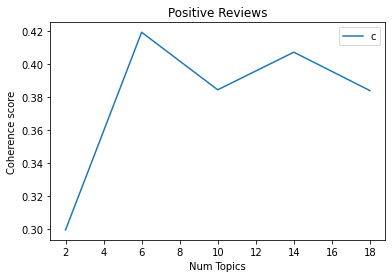

In [100]:
# Show graph
limit=20; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, pos_coherence_values)
plt.title('Positive Reviews')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [101]:
# Print the coherence scores
for m, cv in zip(x, pos_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2993
Num Topics = 6  has Coherence Value of 0.4193
Num Topics = 10  has Coherence Value of 0.3844
Num Topics = 14  has Coherence Value of 0.4072
Num Topics = 18  has Coherence Value of 0.3839


In [104]:
# Build LDA model
pos_lda_model = gensim.models.ldamodel.LdaModel(id2word=id2word_pos, corpus=pos_corpus, num_topics=6, random_state=42,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

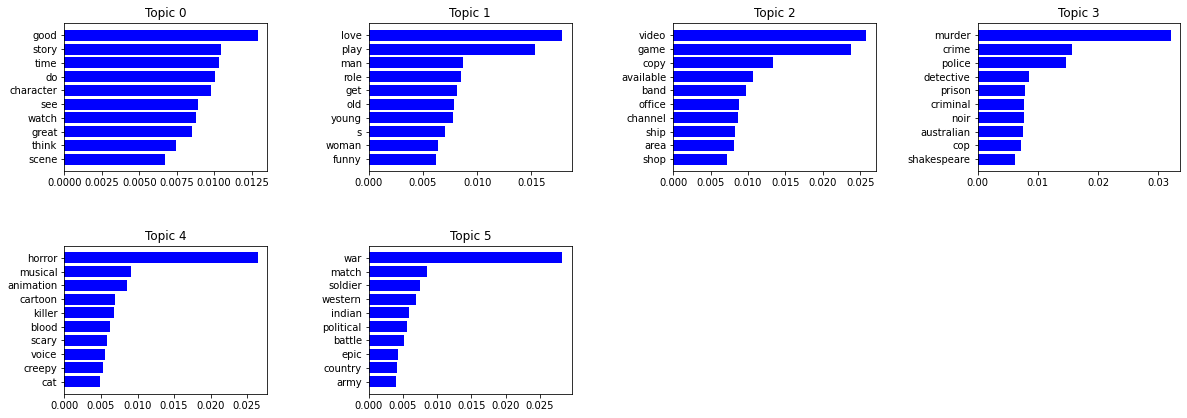

In [105]:
plot_top_words(lda=pos_lda_model, nb_topics=6)

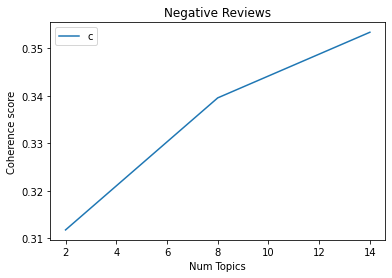

In [102]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, neg_coherence_values)
plt.title('Negative Reviews')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [103]:
# Print the coherence scores
for m, cv in zip(x, neg_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3117
Num Topics = 8  has Coherence Value of 0.3396
Num Topics = 14  has Coherence Value of 0.3534


In [106]:
# Build LDA model - We'll use 8 topics so that it is more comparable to postive model
neg_lda_model = gensim.models.ldamodel.LdaModel(id2word=id2word_neg, corpus=neg_corpus, num_topics=8, random_state=42,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

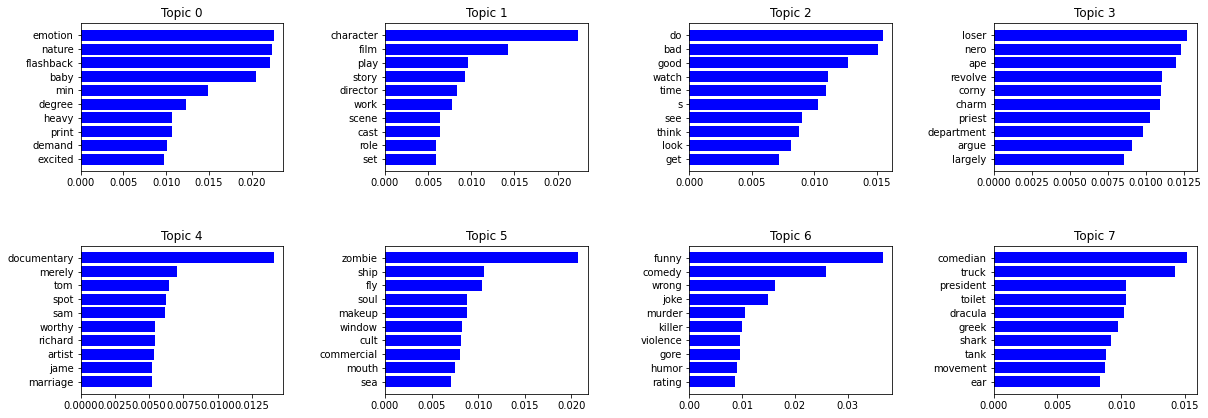

In [107]:
plot_top_words(lda=neg_lda_model, nb_topics=8)